# TTS Models Evaluation - Zero-Shot Voice Cloning

This notebook analyzes the performance metrics of the 2 implemented TTS models:
- **YourTTS**: Multilingual general-purpose model
- **XTTS v2**: Advanced high-quality model

## Evaluated Metrics

1. **RTF (Real-Time Factor)**: Generation time / Audio duration
   - RTF < 1: Faster than real-time
   - RTF = 1: Real-time
   - RTF > 1: Slower than real-time

2. **Generation Time**: Total inference time

3. **Audio Duration**: Duration of generated audio

## 1. Setup and Data Import

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from datetime import datetime

# Style configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [12]:
# Load all JSON result files
results_dir = Path('../results')
json_files = sorted(results_dir.glob('metrics_*.json'))

print(f"Found {len(json_files)} result files:")
for f in json_files:
    print(f"  - {f.name}")

Found 4 result files:
  - metrics_20251119_151303.json
  - metrics_20251119_153217.json
  - metrics_20251119_154046.json
  - metrics_20251119_154844.json


In [13]:
# Function to load and process data
def load_metrics_from_json(json_path):
    """
    Load metrics from a JSON file.
    
    Returns:
        DataFrame with metrics for each model
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Extract general information
    timestamp = data.get('timestamp', 'unknown')
    text = data.get('text', '')
    reference = data.get('reference_audio', '')
    
    # Create DataFrame with results for each model
    models_data = []
    for model in data.get('models', []):
        if model.get('success', False):
            models_data.append({
                'timestamp': timestamp,
                'text': text,
                'model': model['model'],
                'audio_duration': model['audio_duration'],
                'generation_time': model['generation_time'],
                'rtf': model['rtf'],
                'output_path': model['output_path'],
                'success': True
            })
        else:
            models_data.append({
                'timestamp': timestamp,
                'text': text,
                'model': model['model'],
                'error': model.get('error', 'Unknown error'),
                'success': False
            })
    
    return pd.DataFrame(models_data)

# Load all results
all_results = []
for json_file in json_files:
    df = load_metrics_from_json(json_file)
    all_results.append(df)

# Combine all results
if all_results:
    metrics_df = pd.concat(all_results, ignore_index=True)
    print(f"\nLoaded {len(metrics_df)} model evaluations")
    display(metrics_df.head())
else:
    print("\n⚠️ No metrics files found.")
    print("Run first: make run-all TEXT='Your test text'")
    metrics_df = pd.DataFrame()


Loaded 8 model evaluations


,timestamp,text,model,audio_duration,generation_time,rtf,output_path,success
0,2025-11-19T15:13:03.604635,Technology has changed the way we live. From s...,YourTTS,24.548571,11.094934,0.451958,/opt/project/data/generated/yourtts/yourtts_20...,True
1,2025-11-19T15:13:03.604635,Technology has changed the way we live. From s...,XTTS v2,27.694875,132.908410,4.799025,/opt/project/data/generated/xtts/xtts_20251119...,True
2,2025-11-19T15:32:17.309000,Technology has changed the way we live. From s...,YourTTS,24.420862,11.129099,0.455721,/opt/project/data/generated/yourtts/yourtts_20...,True
3,2025-11-19T15:32:17.309000,Technology has changed the way we live. From s...,XTTS v2,31.746757,157.579675,4.963646,/opt/project/data/generated/xtts/xtts_20251119...,True
4,2025-11-19T15:40:46.806802,Music has the power to transport us to differe...,YourTTS,18.300227,10.175870,0.556052,/opt/project/data/generated/yourtts/yourtts_20...,True


## 2. General Statistics

In [14]:
if not metrics_df.empty:
    # Filter only successful results
    successful_df = metrics_df[metrics_df['success'] == True].copy()
    
    if not successful_df.empty:
        print("=" * 60)
        print("STATISTICS BY MODEL")
        print("=" * 60)
        
        # Group by model and calculate statistics
        stats = successful_df.groupby('model').agg({
            'rtf': ['mean', 'std', 'min', 'max'],
            'generation_time': ['mean', 'std', 'min', 'max'],
            'audio_duration': ['mean', 'std']
        }).round(3)
        
        display(stats)
    else:
        print("⚠️ No successful results to analyze.")

STATISTICS BY MODEL


rtf                      generation_time                            \
          mean    std    min    max            mean     std      min      max   
model                                                                           
XTTS v2  5.050  0.291  4.799  5.470         128.033  22.725  105.344  157.580   
YourTTS  0.519  0.078  0.452  0.611          10.504   0.738    9.618   11.129   

        audio_duration         
                  mean    std  
model                          
XTTS v2         25.476  5.173  
YourTTS         20.754  4.433

## 3. RTF (Real-Time Factor) Comparison

RTF measures model efficiency. A lower RTF indicates faster generation.

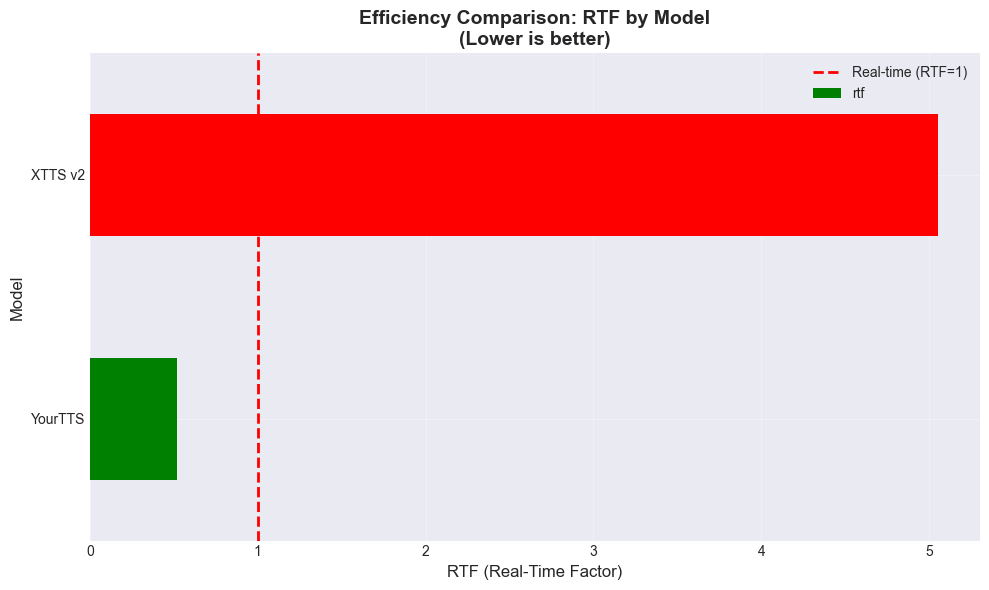


🏆 Fastest model: YourTTS (RTF: 0.52x)
   → Generates audio 1.93x faster than real-time


In [15]:
if not metrics_df.empty and 'rtf' in successful_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bar chart
    models = successful_df.groupby('model')['rtf'].mean().sort_values()
    colors = ['green' if rtf < 1 else 'orange' if rtf < 2 else 'red' for rtf in models]
    
    models.plot(kind='barh', ax=ax, color=colors)
    
    # Add reference line at RTF=1
    ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Real-time (RTF=1)')
    
    ax.set_xlabel('RTF (Real-Time Factor)', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.set_title('Efficiency Comparison: RTF by Model\n(Lower is better)', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    fastest = models.idxmin()
    print(f"\n🏆 Fastest model: {fastest} (RTF: {models[fastest]:.2f}x)")
    
    if models[fastest] < 1:
        print(f"   → Generates audio {1/models[fastest]:.2f}x faster than real-time")
    else:
        print(f"   → Takes {models[fastest]:.2f}x the audio duration to generate")

## 4. Absolute Generation Time

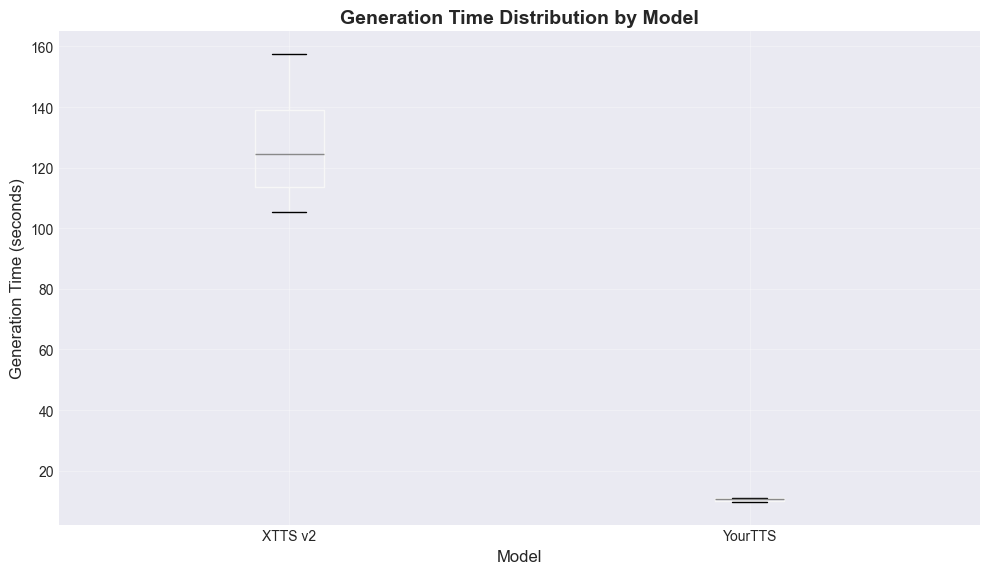

In [16]:
if not metrics_df.empty and 'generation_time' in successful_df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Box plot to show distribution
    successful_df.boxplot(column='generation_time', by='model', ax=ax)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Generation Time (seconds)', fontsize=12)
    ax.set_title('Generation Time Distribution by Model', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Remove automatic title
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Multi-Comparison: RTF vs Generation Time

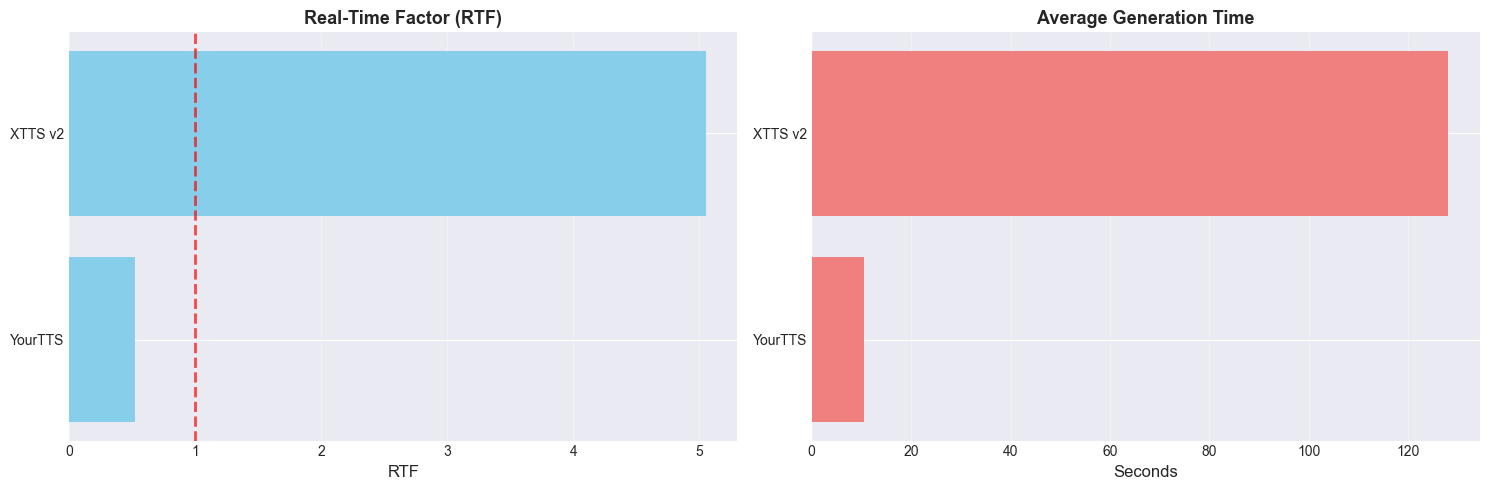

In [17]:
if not metrics_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # RTF comparison
    rtf_data = successful_df.groupby('model')['rtf'].mean().sort_values()
    axes[0].barh(rtf_data.index, rtf_data.values, color='skyblue')
    axes[0].axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7)
    axes[0].set_xlabel('RTF', fontsize=12)
    axes[0].set_title('Real-Time Factor (RTF)', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Generation time comparison
    time_data = successful_df.groupby('model')['generation_time'].mean().sort_values()
    axes[1].barh(time_data.index, time_data.values, color='lightcoral')
    axes[1].set_xlabel('Seconds', fontsize=12)
    axes[1].set_title('Average Generation Time', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

## 6. Success and Failure Analysis

In [18]:
if not metrics_df.empty:
    # Count successes and failures by model
    success_counts = metrics_df.groupby(['model', 'success']).size().unstack(fill_value=0)
    
    print("=" * 60)
    print("SUCCESS RATE BY MODEL")
    print("=" * 60)
    
    # Calculate percentages
    if True in success_counts.columns:
        success_counts['Success Rate (%)'] = (success_counts.get(True, 0) / 
                                               success_counts.sum(axis=1) * 100).round(2)
    
    display(success_counts)
    
    # Show errors if any exist
    failed_df = metrics_df[metrics_df['success'] == False]
    if not failed_df.empty:
        print("\n⚠️ ERRORS FOUND:")
        print("=" * 60)
        for _, row in failed_df.iterrows():
            print(f"Model: {row['model']}")
            print(f"Error: {row.get('error', 'Unknown')}")
            print("-" * 60)

SUCCESS RATE BY MODEL


success,True,Success Rate (%)
model,,
XTTS v2,4,100.0
YourTTS,4,100.0


## 7. Summary and Recommendations

In [19]:
if not metrics_df.empty and not successful_df.empty:
    print("=" * 60)
    print("EVALUATION SUMMARY")
    print("=" * 60)
    
    # Fastest model (lowest RTF)
    fastest_model = successful_df.groupby('model')['rtf'].mean().idxmin()
    fastest_rtf = successful_df.groupby('model')['rtf'].mean().min()
    
    # Most consistent model (lowest std in RTF)
    most_consistent = successful_df.groupby('model')['rtf'].std().idxmin()
    consistency_std = successful_df.groupby('model')['rtf'].std().min()
    
    print(f"\n🏆 Fastest model: {fastest_model}")
    print(f"   Average RTF: {fastest_rtf:.2f}x")
    
    print(f"\n📊 Most consistent model: {most_consistent}")
    print(f"   RTF standard deviation: {consistency_std:.3f}")

EVALUATION SUMMARY

🏆 Fastest model: YourTTS
   Average RTF: 0.52x

📊 Most consistent model: YourTTS
   RTF standard deviation: 0.078

RECOMMENDATIONS
✓ YourTTS can generate audio in real-time
  → Ideal for interactive applications

✓ For maximum speed: use YourTTS
✓ For predictable results: use YourTTS

📝 NOTE: This analysis only considers performance metrics (speed).
   To evaluate audio quality, consider:
   - Speaker Similarity (Resemblyzer, ECAPA-TDNN)
   - Audio Quality (PESQ, STOI)
   - Subjective evaluation (MOS)


## 8. Export Results

In [20]:
if not metrics_df.empty:
    # Export to CSV
    output_csv = results_dir / 'metrics_summary.csv'
    successful_df.to_csv(output_csv, index=False)
    print(f"✓ Summary exported to: {output_csv}")
    
    # Export aggregated statistics
    if not successful_df.empty:
        summary_stats = successful_df.groupby('model').agg({
            'rtf': ['mean', 'std', 'min', 'max'],
            'generation_time': ['mean', 'std', 'min', 'max'],
            'audio_duration': ['mean']
        }).round(3)
        
        output_stats = results_dir / 'metrics_statistics.csv'
        summary_stats.to_csv(output_stats)
        print(f"✓ Statistics exported to: {output_stats}")

✓ Summary exported to: ..\results\metrics_summary.csv
✓ Statistics exported to: ..\results\metrics_statistics.csv
